In [1]:
import os
import rasterio
from rasterio.enums import Resampling
import numpy as np
import pandas as pd
from pyhdf.SD import SD, SDC

In [2]:
!pwd

/mnt/w210/ellecp/irrigated-croplands


In [3]:
import osgeo.gdal

In [4]:
upscale_factor = 10

with rasterio.open("2015.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [5]:
upscale_factor = 10

with rasterio.open("2010.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [ ]:
test = np.array(data)

In [ ]:
clean_data = np.reshape(data, (21600, 43200))

In [ ]:
lidar_dem_path = 'World_e-Atlas-UCSD_SRTM30-plus_v8_Hillshading.tiff'
with rasterio.open(lidar_dem_path) as lidar_dem:
    im_array = lidar_dem.read()
    lidar_dem.bounds

In [ ]:
x, y = 1, 2
t = np.array([x,y])

In [ ]:
with rasterio.open('World_e-Atlas-UCSD_SRTM30-plus_v8_Hillshading.tiff') as map_layer:
    pixels2coords = map_layer.xy(0,5) 
    
def pixel2coord(point):
    """Returns global coordinates to pixel center using base-0 raster index"""
    return(map_layer.xy(point[0],point[1]))

In [ ]:
land_pixels = np.nonzero(clean_data) 
# print(np.unique(imarray))
land_pixel_classes = clean_data[land_pixels].tolist()
print(len(land_pixel_classes))

land_indices = land_pixels 
non_zero_indices = np.array(land_indices)
clean_frame = non_zero_indices.T

# print(clean_frame.shape)
# n = clean_frame.shape[0]
# non_zeros = np.nonzero(test)

# clean_frame_2 = clean_frame 
# clean_frame_df = pd.DataFrame({'lon': clean_frame[:,0], 'lat': clean_frame[:,1]})
# clean_frame_df['labels'] = land_pixel_classes

In [ ]:
t = np.apply_along_axis(pixel2coord, 1, clean_frame)

In [ ]:
import math
def lon_lat_to_modis(point, pixels = 1200):
    lon = point[0]
    lat = point[1]
    R = 6371007.181
    T = 1111950
    xmin = -20015109
    ymax = 10007555
    w = T/pixels
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R*lon_rad*math.cos(lat_rad)
    y = R*lat_rad
    H= int(abs(x -xmin)/T)
    V = int(abs(ymax - y)/T)
    i = ((ymax - y)%T) / w
    j = ((x -xmin)%T)/ w
    return np.array([H, V, i, j])

In [ ]:
modis = np.apply_along_axis(lon_lat_to_modis, 1, t)

In [ ]:
clean_frame_df = pd.DataFrame({'x': clean_frame[:,0], 'y': clean_frame[:,1], 'lon' : t[:,0], 'lat': t[:,1],'H': modis[:,0], 'V': modis[:,1], 'i' : modis[:,2], 'j': modis[:,3] })
clean_frame_df.H = clean_frame_df.H.astype(int)
clean_frame_df.V = clean_frame_df.V.astype(int)
clean_frame_df.i = clean_frame_df.i.astype(int)
clean_frame_df.j = clean_frame_df.j.astype(int)

In [ ]:
example_frame = clean_frame_df[['i','j']][(clean_frame_df['H']== 8) &  (clean_frame_df['V']== 6)]

In [ ]:
pic_gen = list(example_frame.values)

In [ ]:
emtpy_im = np.zeros((1200,1200))

In [ ]:
for i in pic_gen:
    emtpy_im[i[0],i[1]]=1

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(emtpy_im, interpolation='nearest')
plt.show()

In [ ]:
unique_values = clean_frame_df.groupby(['H', 'V']).size().reset_index()

unique_values_2 = clean_frame_df.groupby(['H', 'V']).size().reset_index()
unique_values = unique_values[['H', 'V']]
rel_HV_list = list(unique_values.values)
for i in range(len(rel_HV_list)):
    rel_HV_list[i] = [rel_HV_list[i][0], rel_HV_list[i][1]]
print(unique_values_2)

In [ ]:
print(unique_values_2.columns)

In [ ]:
unique_values_2[unique_values_2[0]<300000].sort_values(by=[0], ascending = False)

In [ ]:
df_list = []
for i in rel_HV_list:
    test_df = clean_frame_df[(clean_frame_df['H'] == i[0]) & (clean_frame_df['V'] == i[1])][['x', 'y', 'H', 'V', 'i', 'j']]
    df_list.append(test_df)

In [ ]:
len(df_list)
df_list[10].shape

In [ ]:
# months = ['2014.01.01',  
#            '2014.02.01', 
#            '2014.03.01', 
#            '2014.04.01', 
#            '2014.05.01', 
#            '2014.06.01', 
#            '2014.07.01',  
#            '2014.08.01', 
#            '2014.09.01', 
#            '2014.10.01', 
#            '2014.11.01',
#            '2014.12.01',
#            '2015.01.01',  
#            '2015.02.01', 
#            '2015.03.01', 
#            '2015.04.01', 
#            '2015.05.01', 
#            '2015.06.01', 
#            '2015.07.01',  
#            '2015.08.01', 
#            '2015.09.01', 
#            '2015.10.01', 
#            '2015.11.01',
#            '2015.12.01']


months = ['2009.01.01',  
           '2009.02.01', 
           '2009.03.01', 
           '2009.04.01', 
           '2009.05.01', 
           '2009.06.01', 
           '2009.07.01',  
           '2009.08.01', 
           '2009.09.01', 
           '2009.10.01', 
           '2009.11.01',
           '2009.12.01',
           '2010.01.01',  
           '2010.02.01', 
           '2010.03.01', 
           '2010.04.01', 
           '2010.05.01', 
           '2010.06.01', 
           '2010.07.01',  
           '2010.08.01', 
           '2010.09.01', 
           '2010.10.01', 
           '2010.11.01',
           '2010.12.01']



In [ ]:
for j in range(len(df_list)):
    H, V = rel_HV_list[j][0], rel_HV_list[j][1]
    print(rel_HV_list[j])
    H_V_string = 'H' + str(H) + 'V' + str(V) 
    file_loc = 'modis/' + H_V_string + '/'
    list_i = np.array(df_list[j].i)
    list_j = np.array(df_list[j].j)
    indices = (list_i, list_j)
    for i in range(len(months)):
#         print(file_loc  + H_V_string + '_' + months[i] + '.hdf')
        ndvi_file = SD(file_loc + H_V_string + '_' + months[i] + '.hdf', SDC.READ)
        #ndvi
        datasets_dic = ndvi_file.datasets()
        sds_obj = ndvi_file.select('1 km monthly NDVI') 
        data = np.array(sds_obj.get()) # get sds data
        df_list[j][months[i]] = data[indices]
    st = df_list[j].iloc[:, 6:30].values
    df_list[j]['max'] = np.amax(st, axis=1)
    df_list[j]['min'] = np.amin(st, axis=1)
    df_list[j]['range'] = df_list[j]['max'] - df_list[j]['min']

In [10]:
ndvi_file = SD('modis/H8V6/H8V6_2010.06.01.hdf', SDC.READ)
#ndvi
datasets_dic = ndvi_file.datasets()
sds_obj_r = ndvi_file.select('1 km monthly red reflectance') 
sds_obj_b = ndvi_file.select('1 km monthly blue reflectance')
sds_obj_g = ndvi_file.select('1 km monthly NIR reflectance')

data_r = np.array(sds_obj_r.get())/10000 # get sds data
data_b = np.array(sds_obj_b.get())/10000
data_g = np.array(sds_obj_g.get())/10000


def apply_mask(pixel):
    if pixel < 0:
        return 1
    else:
        return pixel

filter_function = np.vectorize(apply_mask)
data_r = filter_function(data_r)
data_g = filter_function(data_g)
data_b = filter_function(data_b)

In [11]:
data_r

array([[0.125 , 0.125 , 0.1092, ..., 0.1739, 0.1761, 0.1645],
       [0.1213, 0.1073, 0.0991, ..., 0.1805, 0.1783, 0.1659],
       [0.1186, 0.1016, 0.0988, ..., 0.1713, 0.1635, 0.1693],
       ...,
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ],
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ],
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ]])

In [12]:
from PIL import Image
import numpy as np
rgbArray = np.zeros((1200,1200,3), 'uint8')
rgbArray[..., 0] = data_r*256
rgbArray[..., 1] = data_g*256
rgbArray[..., 2] = data_b*256
img = Image.fromarray(rgbArray)
img.save('myimg.jpeg')

In [ ]:
full_list = pd.concat(df_list, axis=0)

In [ ]:
full_list

In [ ]:
filtered_list = full_list[(full_list['max'] > 4000) & (full_list['min'] < 4000)  &  (full_list['range'] > 2500)]

In [ ]:
filtered_list.shape

In [35]:
filtered_list

,x,y,H,V,i,j,2009.01.01,2009.02.01,2009.03.01,2009.04.01,...,2010.06.01,2010.07.01,2010.08.01,2010.09.01,2010.10.01,2010.11.01,2010.12.01,max,min,range
13394300,7680,8230,7,6,480,1183,2711,2212,1884,1630,...,1544,1493,1666,1574,1704,1627,1714,4412,1493,2919
13394301,7680,8231,7,6,480,1184,2697,2243,1944,1677,...,1565,1540,1566,1612,1748,1694,1737,4380,1540,2840
13394302,7680,8232,7,6,480,1184,2697,2243,1944,1677,...,1565,1540,1566,1612,1748,1694,1737,4380,1540,2840
13394303,7680,8233,7,6,480,1185,2809,2286,1955,1723,...,1550,1542,1611,1601,1874,1762,1773,4236,1542,2694
13394304,7680,8234,7,6,480,1186,2762,2415,2024,1711,...,1632,1602,1639,1627,2085,1787,1759,4613,1602,3011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20344539,14361,39559,31,11,1161,3,1961,1997,2135,2076,...,6116,7629,7998,6860,4690,2585,3113,7998,1654,6344
20345407,14362,39557,31,11,1162,0,1837,2247,1773,1708,...,2409,3974,5652,5423,4449,2665,4005,7836,1358,6478
20345408,14362,39558,31,11,1162,1,1727,1712,1754,1723,...,3007,4117,5916,4354,4221,2274,5156,7949,1399,6550
20345409,14362,39559,31,11,1162,2,1731,1699,1777,1775,...,6347,7220,8004,6982,4240,2265,2444,8729,1506,7223


In [36]:
ds_example

NameError: name 'ds_example' is not defined

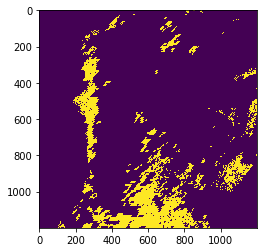

In [38]:
ds_example = filtered_list[['i','j']][(filtered_list['H'] == 8)& (filtered_list['V'] == 6) ]
ds_example = list(ds_example.values)
ds_frame = np.zeros((1200,1200))
for i in ds_example:
    ds_frame[i[0],i[1]] = 1


plt.imshow(ds_frame, interpolation='nearest')
plt.show()

In [ ]:
ds_2010 = np.zeros((21600, 43200), dtype=np.uint8)
x_list = list(filtered_list.x)
y_list = list(filtered_list.y)

In [ ]:
for i in range(len(x_list)):
    ds_2010[x_list[i], y_list[i]] = 1

In [ ]:
np.sum(ds_2010)

In [68]:
import rasterio as rio
with rio.open('World_e-Atlas-UCSD_SRTM30-plus_v8_Hillshading.tiff') as src:
    ras_data = src.read()
    ras_meta = src.profile
with rio.open('2010_ds.tif', 'w', **ras_meta) as dst:
    dst.write(ds_2010, 1)

In [33]:
df_list[1][df_list[1]['max'] > 0.4].shape

(26733, 33)

In [34]:
df_list[1][df_list[1]['min'] < 0.4].shape

(30944, 33)

In [71]:
lidar_dem_path = '2015_ds.tif'
with rasterio.open(lidar_dem_path) as lidar_dem:
    im_array = lidar_dem.read()
    lidar_dem.bounds
im_array.shape

(1, 21600, 43200)

In [28]:
import urllib 
url_base = 'https://e4ftl01.cr.usgs.gov/MOLT/MOD13A3.006/'

strings = ['2009.01.01',  
           '2009.02.01', 
           '2009.03.01', 
           '2009.04.01', 
           '2009.05.01', 
           '2009.06.01', 
           '2009.07.01',  
           '2009.08.01', 
           '2009.09.01', 
           '2009.10.01', 
           '2009.11.01',
           '2009.12.01',
           '2010.01.01',  
           '2010.02.01', 
           '2010.03.01', 
           '2010.04.01', 
           '2010.05.01',
          ]

html_list = []
for i in strings:
    html_list.append(url_base + i)

clean_list =[]
for i in html_list:
    response = urllib.request.urlopen(i)
    html = response.read()
    all_list= str(html).split('=')
    for j in all_list:
#         print(j)
        if 'hdf' in j:
            if 'xml' not in j:
                url = i+j[1:46]
                v_val = int(url[76:78])
                h_val = int(url[73:75])
                z = [h_val,v_val]
                if z == [13,14]:
                    clean_list.append(i+ '/' + j[1:46])
len(clean_list)

17

In [ ]:
land_pixels

In [ ]:
clean_list[1]

In [30]:
import requests # get the requsts library from https://github.com/requests/requests
 
class SessionWithHeaderRedirection(requests.Session):
    AUTH_HOST = 'urs.earthdata.nasa.gov'
    def __init__(self, username, password):
        super().__init__()
        self.auth = (username, password)
 
    def rebuild_auth(self, prepared_request, response):
        headers = prepared_request.headers
        url = prepared_request.url
        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)
            if (original_parsed.hostname != redirect_parsed.hostname) and \
                redirect_parsed.hostname != self.AUTH_HOST and \
                original_parsed.hostname != self.AUTH_HOST:
                del headers['Authorization']
        return

username = "ecproust@berkeley.edu"
password= "Tabt5yge6!"
 
session = SessionWithHeaderRedirection(username, password)
for i in clean_list:
    url = i
    v_val = str(int(url[77:79]))
    h_val = str(int(url[74:76]))
    date =  url[45:55]
    HV_val = 'H' + h_val + 'V' + v_val

    filename = 'modis/' + HV_val + '/' + HV_val + '_' + date + '.hdf'
    response = session.get(url, stream=True)
    try:
        with open(filename, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=1024*1024):
                fd.write(chunk)
    except:
        os.mkdir('modis/'+ HV_val)
        print(HV_val)
        with open(filename, 'wb') as fd:
            for chunk in response.iter_content(chunk_size=1024*1024):
                fd.write(chunk)

In [35]:
url[74:]

'h'

In [33]:
str(url[77:79])

'03'

In [ ]:
import urllib 
url_base = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q2.006/'
strings = ['2006.01.01','2007.01.01', '2008.01.01', '2009.01.01', '2010.01.01', '2011.01.01', '2012.01.01', '2013.01.01', '2014.01.01' ,'2015.01.01' ]

html_list = []
for i in strings:
    html_list.append(url_base + i)

print(html_list)
clean_list =[]
for i in html_list:
    response = urllib.request.urlopen(i)
    html = response.read()
    all_list= str(html).split('=')
    for j in all_list:
#         print(j)
        if 'hdf' in j:
            if 'xml' not in j:
#                 print(i+j[1:46])
                clean_list.append(i+j[1:46])

In [101]:
url.index('h10')

73

In [102]:
url.index('v03')

76

In [ ]:

import rasterio as rio    

with rio.open('2005.tif') as src:
    ras_data = src.read()
    ras_meta = src.profile

# make any necessary changes to raster properties, e.g.:
ras_meta['nodata'] = -99

with rio.open('2010.tif', 'w', **ras_meta) as dst:
    dst.write(map_10, 1)